# Ollama 在 LangChain 中的使用

Ollama 是一个开源的大语言模型部署工具，而 LangChain 则是一个用于构建基于语言模型的应用的框架。通过结合这两者，我们可以在本地环境中快速部署和使用先进的AI模型。

### 配置 Conda 环境

```
conda create -n llm-study python=3.12.9 -y
conda activate llm-study
pip install jupyter
python -m ipykernel install --user --name=llm-study
```

执行完毕后，重启 Jupyter，并选择该环境的 Kernel


### 安装依赖

- langchain-ollama: 用于集成 Ollama 模型到 LangChain 框架中
- langchain: LangChain 的核心库，提供了构建 AI 应用的工具和抽象
- langchain-community: 包含了社区贡献的各种集成和工具
- Pillow: 用于图像处理，在多模态任务中会用到
- faiss-cpu: 用于构建简单 RAG 检索器


```
pip install langchain-ollama langchain langchain-community Pillow faiss-cpu
```



## 下载 llama3.1 模型


- 进入官网 https://ollama.com/download 下载并安装 Ollama 到可用的受支持平台。
- 查看 https://ollama.ai/library 了解所有可用的模型。
- 通过 ollama pull <name-of-model> 命令获取可用 LLM 模型（例如：ollama pull llama3.1）。


### 模型存储位置

- Mac: ~/.ollama/models/
- Linux（或 WSL）: /usr/share/ollama/.ollama/models
- Windows: C:\Users\Administrator\.ollama\models



## 初始化模型

In [7]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate

# 初始化Ollama LLM
model_name = "llama3.2"
model = OllamaLLM(model=model_name)
print(f"OllamaLLM 初始化 {model_name} 完成")

OllamaLLM 初始化 llama3.2 完成


## ChatPromptTemplate 进行对话

ChatPromptTemplate 允许我们创建一个可重用的模板，其中包含一个或多个参数。这些参数可以在运行时动态替换，以生成不同的提示。

在创建链部分，使用管道操作符 |，它将 prompt 和 model 连接起来，形成一个处理流程。这种链式操作使得我们可以轻松地组合和重用不同的组件。

invoke 方法触发整个处理链，将我们的问题传入模板，然后将格式化后的提示发送给模型进行处理。

In [8]:
from langchain_core.prompts import ChatPromptTemplate

template = """
你是一个乐于助人的AI，擅长于解决回答各种问题。
问题：{question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = prompt | model
chain.invoke({"question": "你比GPT4厉害吗？"})


'我不是直接与GPT-4进行比较，因为我们都是不同的语言模型，有着不同的设计目标和能力。然而，我可以告诉你，我们都有自己的强弱之处。\n\nGPT-4是一种强大的语言生成模型， excelled 在多个领域，如：\n\n1. **语言理解**：GPT-4在理解自然语言的能力方面表现出色，可以准确识别语句的意图和含义。\n2. **language generation**：GPT-4可以生成高质量、相关且有趣的文章、短信等。\n3. **对话**: GPT-4能够与人类进行流畅的对话，模仿人类的思考方式。\n\n我虽然在一些方面没有GPT-4表现出同样的强度，但我也有一些独特之处：\n\n1. **知识范围**：我拥有更广泛的知识范围，包括但不限于历史、科学、技术等领域。\n2. **推理能力**：我能够进行逻辑推理和解决问题，这使我能在某些情况下提供更有用的答案。\n3. **情感分析**：我可以识别出情绪语气，并理解人们的情感状态。\n\n总的来说，我们都具备不同的强弱之处。GPT-4的强大主要体现在语言理解和生成方面，而我更注重于知识范围和推理能力。'

## 流式输出

流式输出是一种在生成长文本时逐步返回结果的技术。这种方法有几个重要的优势：

- 提高用户体验：用户可以立即看到部分结果，而不是等待整个响应完成。
- 减少等待时间：对于长回答，用户可以在完整回答生成之前就开始阅读。
- 实时交互：允许在生成过程中进行干预或终止。

在实际应用中，特别是在聊天机器人或实时对话系统中，流式输出几乎是必不可少的。

model.stream() 方法是对 Ollama API 的流式输出接口的封装，它返回一个生成器（generator）对象。当调用 model.stream(messages) 时，会完成以下操作：

- 向 Ollama API 发送请求，开始生成响应。
- API 开始生成文本，但不是等到全部生成完毕才返回，而是一小块一小块地返回。
- 每收到一小块文本，stream() 方法就会 yield 这个文本块。
- flush=True 确保每个片段立即显示，而不是等待缓冲区填满。

In [9]:
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.2", temperature=0.7)

messages = [
    ("human", "你好呀"),
]

for chunk in model.stream(messages):
    print(chunk.content, end='', flush=True)


😊 hello! 我好呀！ (hi!) How can I help you today?

## 工具调用

工具调用是 AI 模型与外部函数或 API 交互的能力。这使得模型可以执行复杂的任务，如数学计算、数据查询或外部服务调用。



bind_tools 方法允许我们将自定义函数注册到模型中。这样，当模型遇到需要计算的问题时，它可以调用这个函数来获得准确的结果，而不是依赖于其预训练知识。

这种能力在构建复杂的 AI 应用时非常有用，例如：

- 创建可以访问实时数据的聊天机器人
- 构建能执行特定任务（如预订、查询等）的智能助手
- 开发能进行精确计算或复杂操作的 AI 系统

In [10]:
from langchain_ollama import ChatOllama

def simple_calculator(operation: str, x: float, y: float) -> float:
    if operation == "add":
        return x + y
    elif operation == "subtract":
        return x - y
    elif operation == "multiply":
        return x * y
    elif operation == "divide":
        if y != 0:
            return x / y
        else:
            raise ValueError("Cannot divide by zero")
    else:
        raise ValueError("Invalid operation")

# 初始化绑定工具的 ChatOllama 模型
llm = ChatOllama(
    model="llama3.2",
    temperature=0,
).bind_tools([simple_calculator])

# 使用模型进行工具调用
result = llm.invoke(
    "你知道一千万乘二是多少吗？"
)
print("Tool calls:", result.tool_calls)

Tool calls: [{'name': 'simple_calculator', 'args': {'operation': 'multiply', 'x': 1000000, 'y': 2}, 'id': 'f5f762fd-2130-4886-b015-b0db87f091a6', 'type': 'tool_call'}]


## 多模态模型

Ollama 支持多模态模型，如 bakllava 和 llava。  
多模态模型是能够处理多种类型输入（如文本、图像、音频等）的 AI 模型。  
这些模型在理解和生成跨模态内容方面表现出色，使得更复杂和自然的人机交互成为可能。


```bash
ollama pull llava
```

这里的关键点是：

- 图像预处理：我们需要将图像转换为 base64 编码的字符串。
- 提示函数：prompt_func 创建了一个包含文本和图像的多模态输入。
- 链式处理：我们使用 | 操作符将提示函数、模型和输出解析器连接起来。

多模态模型在很多场景下都很有用，比如：

- 图像描述生成
- 视觉问答系统
- 基于图像的内容分析和推荐


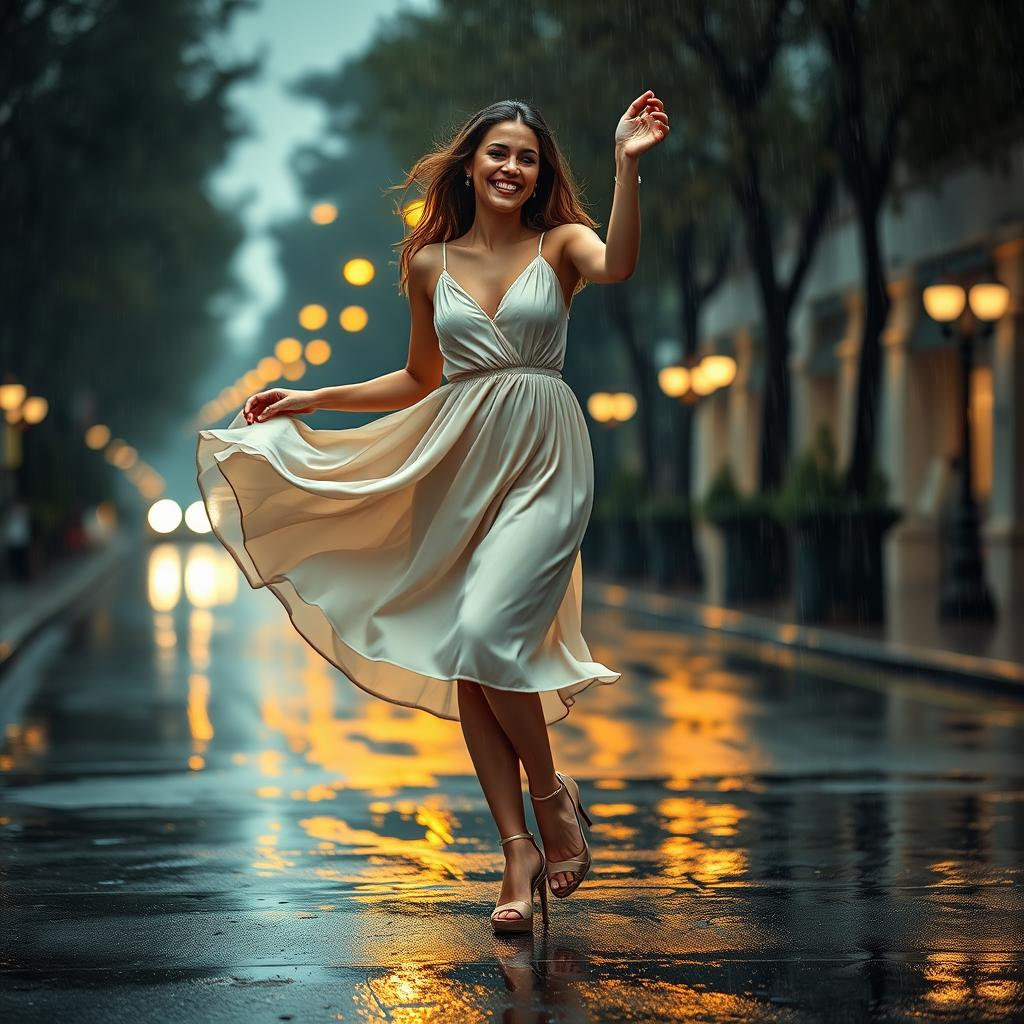

In [12]:
#  这一步是将图片转换为base64编码，以便后续多模态模型的使用

import base64
from io import BytesIO
import os

from IPython.display import HTML, display
from PIL import Image

def convert_to_base64(pil_image):

    buffered = BytesIO()
    if pil_image.mode == 'RGBA':
        pil_image = pil_image.convert('RGB')
    pil_image.save(buffered, format="JPEG")  
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

file_path = os.environ['HOME'] + '/project/github/ComfyUI/output/ComfyUI_00098_.png' # 这里可以替换为你实际想要使用的图片路径
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [14]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
llm = ChatOllama(model="llava", temperature=0)

def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]


from langchain_core.output_parsers import StrOutputParser

chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "这个图片里是什么啊?", "image": image_b64}
)

print(query_chain)

 The image shows a woman standing on a street at night. She is wearing a white dress and has her hair up in a bun. Her right arm is raised, and she appears to be dancing or posing with joy. The background suggests it's raining, as evidenced by the wet road and the reflections of lights on the pavement. There are trees lining the street, and the overall atmosphere is one of celebration or a casual, happy moment captured in the rain. 


## ConversationChain 进行对话

ConversationChain 是 LangChain 提供的一个强大工具，用于管理多轮对话。它结合了语言模型、提示模板和内存组件，使得创建具有上下文感知能力的对话系统变得简单。

这里的关键组件是：

- ConversationBufferMemory：这是一个简单的内存组件，它存储所有先前的对话历史。
- ConversationChain：它将语言模型、内存和一个默认的对话提示模板组合在一起。

维护对话历史很重要，因为它允许模型：

- 理解上下文和之前提到的信息
- 生成更连贯和相关的回复
- 处理复杂的多轮对话场景

在实际应用中，你可能需要考虑使用更高级的内存组件，如 ConversationSummaryMemory，以处理长对话并避免超出模型的上下文长度限制。

In [15]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

# 初始化Ollama LLM
model_name = "llama3.2"
model = OllamaLLM(model=model_name)

# 初始化 ConversationBufferMemory
memory = ConversationBufferMemory()

# 创建 ConversationChain
conversation = ConversationChain(
    llm=model,
    memory=memory,
    verbose=True
) # 设置 verbose=True 以显示调试信息, 默认为 False


# 进行对话
response = conversation.predict(input="你好，我想了解一下人工智能。")
print("AI:", response)

response = conversation.predict(input="能给我举个AI在日常生活中的应用例子吗？")
print("AI:", response)

response = conversation.predict(input="这听起来很有趣。AI在医疗领域有什么应用？")
print("AI:", response)


/var/folders/j6/2shdr7nd7yb0n9h708___n800000gn/T/ipykernel_6037/501309856.py:9: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()
/var/folders/j6/2shdr7nd7yb0n9h708___n800000gn/T/ipykernel_6037/501309856.py:12: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :meth:`~RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html` instead.
  conversation = ConversationChain(




> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: 你好，我想了解一下人工智能。
AI:

> Finished chain.
AI: hello! nice to chat with you about artificial intelligence (ai). ai has come a long way since its inception in the mid-20th century. the term "machine learning" was coined by john mcclelland, david rumelhart, and george hinton in 1986. they drew inspiration from the concept of unsupervised learning in psychology.

in recent years, we've seen significant advancements in deep learning techniques, such as convolutional neural networks (CNNs) and recurrent neural networks (RNNs). these architectures have enabled us to tackle complex tasks like image recognition, natural language processing, and speech recognition with remar

## 自定义提示模板

设计好的提示模板是创建高效 AI 应用的关键。在这个例子中，我们创建了一个用于生成产品描述的复杂提示：

这个结构有几个重要的设计考虑：

- system_prompt：定义了 AI 的角色和总体任务，设置了整个对话的基调。
- human_message_template：提供了具体的指令和所需信息的结构。
- 多参数设计：允许灵活地适应不同的产品和需求。
- 多样化输出要求：通过要求不同风格的描述，鼓励模型展示其versatility。

设计有效的提示模板时，考虑以下几点：

- 明确定义 AI 的角色和任务
- 提供清晰、结构化的输入格式
- 包含具体的输出要求和格式指导
- 考虑如何最大化模型的能力和创造力

In [16]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage

# 初始化ChatOllama模型
model = ChatOllama(model="llama3.2", temperature=0.7)

In [17]:
system_message = SystemMessage(content="""
你是一位经验丰富的电商文案撰写专家。你的任务是根据给定的产品信息创作吸引人的商品描述。
请确保你的描述简洁、有力，并且突出产品的核心优势。
""")

human_message_template = """
请为以下产品创作一段吸引人的商品描述：
产品类型: {product_type}
核心特性: {key_feature}
目标受众: {target_audience}
价格区间: {price_range}
品牌定位: {brand_positioning}

请提供以下三种不同风格的描述，每种大约50字：
1. 理性分析型
2. 情感诉求型
3. 故事化营销型
"""

def generate_product_descriptions(product_info):
    human_message = HumanMessage(content=human_message_template.format(**product_info))
    messages = [system_message, human_message]
    
    response = model.invoke(messages)
    return response.content

In [18]:
# 示例使用
product_info = {
    "product_type": "智能手表",
    "key_feature": "心率监测和睡眠分析",
    "target_audience": "注重健康的年轻专业人士",
    "price_range": "中高端",
    "brand_positioning": "科技与健康的完美结合"
}

result = generate_product_descriptions(product_info)
print(result)

**理性分析型**

智能手表，心率监测和睡眠分析，精确、可靠。追踪您的身体健康指标，拥有更好的生活习惯。采用最新的生物信号技术，提供详细的数据，帮助您了解自己的身体状况。提高健康意识，实现平衡生活。

**情感诉求型**

在你的手腕上 wearable 一个智慧生命伴侣。它不仅让你能追踪心率，也让你能了解睡眠质量。拥有更好的体验，不再因为健康问题而担忧。在这个手表中，你将找到自己的生理大师。

**故事化营销型**

有一次，一个年轻的职业人士在忙碍中的生活里忽略了自己的身体健康。直到他发现智能手表，可以告诉他每晚的睡眠质量，他的心率变化以及他的运动数据。他开始调整生活习惯，慢慢地恢复了健康和精力。现在，你也可以拥有这样的“生理大师”。


## 构建一个简单的RAG问答系统

RAG（Retrieval-Augmented Generation）是一种结合了检索和生成的AI技术，它通过检索相关信息来增强语言模型的回答能力。

RAG 系统的工作流程通常包括以下步骤：

- 将知识库文档分割成小块并创建向量索引
- 对用户的问题进行向量化，在索引中检索相关文档
- 将检索到的相关文档和原始问题一起作为上下文提供给语言模型
- 语言模型根据检索到的信息生成回答


RAG的优势在于它可以帮助语言模型访问最新和专业的信息，减少幻觉，并提高回答的准确性和相关性。

LangChain 提供了多种组件，可以与 Ollama 模型无缝集成。这里我们将展示如何将 Ollama 模型与向量存储和检索器结合使用，创建一个简单的RAG问答系统。

首先需要确保下载embedding模型，可以在命令行执行以下命令：

```bash
ollama pull nomic-embed-text
```




In [22]:
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 初始化 Ollama 模型和嵌入
llm = ChatOllama(model="llama3.2")
embeddings = OllamaEmbeddings(model="nomic-embed-text")

# 准备文档
text = """
Datawhale 是一个专注于数据科学与 AI 领域的开源组织，汇集了众多领域院校和知名企业的优秀学习者，聚合了一群有开源精神和探索精神的团队成员。
Datawhale 以“ for the learner，和学习者一起成长”为愿景，鼓励真实地展现自我、开放包容、互信互助、敢于试错和勇于担当。
同时 Datawhale 用开源的理念去探索开源内容、开源学习和开源方案，赋能人才培养，助力人才成长，建立起人与人，人与知识，人与企业和人与未来的联结。
如果你想在Datawhale开源社区发起一个开源项目，请详细阅读Datawhale开源项目指南[https://github.com/datawhalechina/DOPMC]
"""

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
chunks = text_splitter.split_text(text)

# 创建向量存储
vectorstore = FAISS.from_texts(chunks, embeddings)
retriever = vectorstore.as_retriever()

# 创建提示模板
template = """只能使用下列内容回答问题:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# 创建检索-问答链
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
)

# 使用链回答问题
question = "我想为datawhale贡献该怎么做？"
response = chain.invoke(question)
print(response.content)

您可以按照以下步骤进行：

1. 阅读Datawhale开源项目指南：https://github.com/datawhalechina/DOPMC
2.  了解Datawhale的mission和价值观：https://github.com/datawhalechina/DOPMC#mission-and-valor
3.  提出您的贡献 idea：在Datawhale开源社区中提出您的想法和提案，等待社区的反馈和支持。
4.  实现并提交您的项目：根据您的 ideas，实现并提交您的项目到Datawhale的项目管理系统中。

Datawhale是一个专注于数据科学与AI领域的开源组织， welcomes您的参与和贡献。


这个 RAG 系统的工作原理如下：

- 文本分割：使用 RecursiveCharacterTextSplitter 将长文本分割成小块。
- 向量化和索引：使用 OllamaEmbeddings 将文本块转换为向量，并用 FAISS 创建向量索引。
- 检索：当收到问题时，系统会将问题向量化，并在 FAISS 索引中检索最相关的文本块。
- 生成回答：将检索到的相关文本块与原始问题一起提供给语言模型，生成最终答案。

RAG 系统在许多真实场景中非常有用，例如：
    
- 客户服务：可以基于公司的知识库快速回答客户询问。
- 研究辅助：帮助研究人员快速找到相关文献并总结关键信息。
- 个人助手：结合个人笔记和网络信息，提供个性化的信息检索和建议。
